In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import scipy.optimize as optimize

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [2]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

In [92]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
#     print(centroid_all.columns)
    centroid_above = centroid_all.loc[centroid_all.distance > 0]
    centroid_below = centroid_all.loc[centroid_all.distance == 0]
    del centroid_below['distance']
    misDistance = centroid_above.groupby(['origin']).agg({'distance':min})
    misDistance['distance'] = misDistance['distance']
    centroid_below = centroid_below.merge(misDistance,on=['origin'])
#     centroid_all.loc[centroid_all.distance == 0, 'distance'] = centroid_all.loc[centroid_all.distance > 0, 'distance'].min()*0.5
    centroid_all = pd.concat([centroid_above,centroid_below],axis=0)
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [93]:
target_columns = ['S000']
for city, state, conties in cities:
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
    training_set.to_csv('cities/%s.csv'%city,index=False)
#     break

New York City
Los Angeles
Chicago
Houston
Boston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin


# baseline

### unconstrain model, power law

In [29]:

def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test

# bucked unconstrained power law with distance

In [40]:


def power_law_k(x,a):
    return (x[:,0]**a)*x[:,1]*x[:,2]*x[:,3]

def fit_dist(data,target,k):
    data['k'] = k
    X = data[['distance', target+'jobs', target+'residence','k']].values
    y = data[target+'flow'].values
    pars, cov = optimize.curve_fit(f=power_law_k, xdata=X, ydata=y, bounds=(-np.inf, np.inf))
    return k,pars[0]

def fit_piece_power_law(data,target,k):
    bins_list = data['bin'].unique()    
    bin_to_model = {}
    for b in bins_list:
        subData = data[data['bin'] == b]
        model = fit_dist(subData,target,k)
#         k = model[0]
        bin_to_model[b] = model[1]
        
    return [k,bin_to_model]

def predict_piece_powerlaw(data,target,model):
    k = model[0]
    bin_to_model =  model[1]
    data[target+'a'] = data['bin'].apply(lambda x:bin_to_model[x]).astype(float)
    data[target+'pred'] = (data['distance']**data[target+'a'])*data[target+'jobs']*data[target+'residence']*k
    return data

# bucked gravity model

In [31]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def bucked_power_law(x,f):
    return f*(x[:,0]*x[:,1]*x[:,2])
def unconstrained_bucked_constant_fit(data, target):
    binf = {}
    X = data[[target+'jobs',target+'residence']].values
    y = data[target+'flow'].values
    model = sm.OLS(y,X)
    results = model.fit()
    k = results.params[0]
    data[target+'k'] = results.params[0]
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = results.params[0]
    return (results.params[0],binf)
def unconstrained_bucked_constant_predict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

In [32]:
def unconstrained_bucked_constant_kfit(data, target,k):
    binf = {}
    data[target+'k'] = k
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = results.params[0]
    return binf
def unconstrained_bucked_constant_kpredict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

In [33]:
def unconstrained_bucked_nok_constant_fit(data, target):
    binf = {}
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = results.params[0]
    return binf
def unconstrained_bucked_nok_constant_predict(test,target,binf):
    test[target+'f'] = test['bin'].apply(lambda x:binf[x])
    test[target+'pred'] = test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

In [34]:
def datacut(df,bins,bintarget):
    df['bin'] = pd.cut(np.log(df['distance']), bins=bins)
    if len(df.bin.unique())!=bintarget:
        bins = bins+1
#         print('empty bin exist, increase bins')
        return datacut(df,bins,bintarget)
    else:
        return df

# out of sample bins tuning

In [90]:
def findBestBin(df):
    
    minMSE = 1000
    bestBin = 0
    
    for bins in np.arange(5,100,5):
        dfFDoutput = pd.DataFrame()
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        df['bin'] = pd.cut(np.log(df['distance']), bins=bins)
        df['bin'] = df.bin.astype(str)
        skf = StratifiedKFold(n_splits=5)
        X = df[['origin', 'destination', 'distance', target+'residence',
           target+'jobs', target+'flow']].values
        y = df[['bin']].values
        skf.get_n_splits(X,y)

        for train_index, test_index in skf.split(X, y):
            train_set, test_set = df.loc[train_index], df.loc[test_index]
            
            k = 1
            # fd
            binf = unconstrained_bucked_constant_kfit(train_set, target,k)
            test_fd = unconstrained_bucked_constant_predict(test_set,target,k,binf)
            dfFDoutput = pd.concat([dfFDoutput,test_fd])
        tempMSE = mean_squared_error(dfFDoutput[target+'flow'],dfFDoutput[target+'pred'])
        if tempMSE < minMSE:
            minMSE = tempMSE
            bestBin = len(df.bin.unique())
        print('tested bin:',bins,'new mse:', round(tempMSE,3), 'lowest mse:', round(minMSE,3), 'best bin:',bestBin , end='\r')

    return (minMSE,bestBin)
           


In [91]:
resultsFD = {}
for city in cities:
    if '.csv' in city:
        print(city)
        df = pd.read_csv(citiesDir+city)
        minMSE,bestBin = findBestBin(df)
        resultsFD[city] = [minMSE,bestBin]

Chicago.csv
Phoenix.csv 95 new mse: 16.318 lowest mse: 15.297 best bin: 24
New York City.csvw mse: 16.612 lowest mse: 16.543 best bin: 35
San Diego.csv5 new mse: 4.562 lowest mse: 4.556 best bin: 60
San Jose.csv95 new mse: 46.732 lowest mse: 45.895 best bin: 60
Austin.csv: 95 new mse: 60.179 lowest mse: 58.478 best bin: 15
San Antonio.csvnew mse: 136.249 lowest mse: 124.781 best bin: 25
Philadelphia.csvew mse: 44.955 lowest mse: 44.143 best bin: 25
Dallas.csv: 95 new mse: 23.594 lowest mse: 21.41 best bin: 10
Houston.csv 95 new mse: 28.265 lowest mse: 27.449 best bin: 35
Boston.csv: 95 new mse: 41.78 lowest mse: 38.047 best bin: 200
Los Angeles.csvnew mse: 55.283 lowest mse: 53.228 best bin: 34


In [92]:
resultsFD

{'Chicago.csv': [15.296910058185397, 24],
 'Phoenix.csv': [16.54343023233668, 35],
 'New York City.csv': [4.555677565212514, 60],
 'San Diego.csv': [45.89472524088056, 60],
 'San Jose.csv': [58.47777959191956, 15],
 'Austin.csv': [124.78121123441194, 25],
 'San Antonio.csv': [44.14306330283364, 25],
 'Philadelphia.csv': [21.409613382233776, 10],
 'Dallas.csv': [27.44934322722438, 35],
 'Houston.csv': [38.047152968413414, 20],
 'Boston.csv': [53.22769948107562, 34],
 'Los Angeles.csv': [6.2920028328583415, 20]}

In [93]:
def findBestBin(df):
    
    minMSE = 1000
    bestBin = 0
    
    for bins in np.arange(5,100,5):
        dfPieceoutput = pd.DataFrame()
        df['bin'] = pd.cut(np.log(df['distance']), bins=bins)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        df['bin'] = df['bin'].astype(str)

        skf = StratifiedKFold(n_splits=5)
        X = df[['origin', 'destination', 'distance', target+'residence',
           target+'jobs', target+'flow']].values
        y = df[['bin']].values
        skf.get_n_splits(X,y)

        for train_index, test_index in skf.split(X, y):
            train_set, test_set = df.loc[train_index], df.loc[test_index]

            try:
                # piecewise
                bin_to_model = fit_piece_power_law(train_set,target,k)
                df_piece = predict_piece_powerlaw(test_set,target,bin_to_model)
                dfPieceoutput = pd.concat([dfPieceoutput,df_piece])
            except RuntimeError:
                print("RuntimeError")
                return (minMSE,bestBin)
            tempMSE = mean_squared_error(dfPieceoutput[target+'flow'],dfPieceoutput[target+'pred'])
            if tempMSE<minMSE:
#                 print('test bin:',bins,'new mse', round(minMSE,3), end='\r')
                minMSE = tempMSE
                bestBin = len(df.bin.unique())
            
            print('tested bin:',bins,'new mse', round(tempMSE,3), 'lowest mse', round(minMSE,3), 'best bin', bestBin, end='\r')


        

    return (minMSE,bestBin)
           

In [94]:
resultsPiece = {}
for city in cities:
    if '.csv' in city:
        print(city)
        df = pd.read_csv(citiesDir+city)
        minMSE,bestBin = findBestBin(df)
        resultsPiece[city] = [minMSE,bestBin]

Chicago.csv
Phoenix.csv 95 new mse 16.413 lowest mse 13.667 best bin 65
RuntimeError45 new mse 14.556 lowest mse 13.303 best bin 20
New York City.csv
San Diego.csv5 new mse 4.659 lowest mse 3.094 best bin 94
RuntimeError75 new mse 42.196 lowest mse 37.095 best bin 20
San Jose.csv
Austin.csv: 95 new mse 61.315 lowest mse 39.592 best bin 15
San Antonio.csvnew mse 136.383 lowest mse 75.846 best bin 25 best bin 25
Philadelphia.csvew mse 44.945 lowest mse 39.693 best bin 10
Dallas.csv: 95 new mse 22.755 lowest mse 20.89 best bin 500
RuntimeError45 new mse 24.884 lowest mse 22.979 best bin 30
Houston.csv
Boston.csv: 95 new mse 41.716 lowest mse 33.011 best bin 20
RuntimeError20 new mse 38.382 lowest mse 38.382 best bin 20
Los Angeles.csv
RuntimeError60 new mse 4.692 lowest mse 4.542 best bin 5


In [95]:
resultsPiece

{'Chicago.csv': [13.666646873291818, 65],
 'Phoenix.csv': [13.303046100205423, 20],
 'New York City.csv': [3.093777565996926, 94],
 'San Diego.csv': [37.09505120876096, 20],
 'San Jose.csv': [39.59232599011278, 15],
 'Austin.csv': [75.84569843421757, 25],
 'San Antonio.csv': [39.692735782053504, 10],
 'Philadelphia.csv': [20.89015833530276, 50],
 'Dallas.csv': [22.979366841149982, 30],
 'Houston.csv': [33.01091616866879, 20],
 'Boston.csv': [38.381858900790185, 20],
 'Los Angeles.csv': [4.54177762752385, 5]}

In [85]:
resultsBaseline = {}
for city in cities:
    if '.csv' in city:
        print(city)
        df = pd.read_csv(citiesDir+city)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        kf = KFold(n_splits=5)
        X = df[['origin', 'destination', 'distance', target+'residence',
           target+'jobs' ]].values
        y = df[[target+'flow']].values
        kf.get_n_splits(X,y)
        df_baseline_output = pd.DataFrame()
        for train_index, test_index in kf.split(X, y):
            train_set, test_set = df.loc[train_index], df.loc[test_index]
            pars = baseline_fit(train_set,target)
            df_baseline = baseline_predict(test_set,target,pars)
            df_baseline_output = pd.concat([df_baseline,df_baseline_output])
        resultsBaseline[city] = mean_squared_error(df_baseline_output[target+'flow'],df_baseline_output[target+'pred'])

Chicago.csv
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv
Houston.csv
Boston.csv
Los Angeles.csv


In [97]:
pd.DataFrame({'city':resultsBaseline.keys(),
              'baseline MSE': list(resultsBaseline.values()),
              'piecewise MSE':np.array(list(resultsPiece.values()))[:,0],
             'piecewise bins':np.array(list(resultsPiece.values()))[:,1],
            'f(d) MSE':np.array(list(resultsFD.values()))[:,0],
            'f(d) bins':np.array(list(resultsFD.values()))[:,1]})

,city,baseline MSE,piecewise MSE,piecewise bins,f(d) MSE,f(d) bins
0,Chicago.csv,15.605111,13.666647,65.0,15.296910,24.0
1,Phoenix.csv,16.520842,13.303046,20.0,16.543430,35.0
2,New York City.csv,4.564066,3.093778,94.0,4.555678,60.0
3,San Diego.csv,45.405296,37.095051,20.0,45.894725,60.0
4,San Jose.csv,58.339710,39.592326,15.0,58.477780,15.0
5,Austin.csv,126.873250,75.845698,25.0,124.781211,25.0
6,San Antonio.csv,43.811916,39.692736,10.0,44.143063,25.0
7,Philadelphia.csv,20.653639,20.890158,50.0,21.409613,10.0
8,Dallas.csv,27.260284,22.979367,30.0,27.449343,35.0
9,Houston.csv,37.597487,33.010916,20.0,38.047153,20.0


### apply bins to insample

In [113]:
# same k for both
mseDict = {}
bindffDict = {}
binpieceDict = {}
cities = os.listdir('cities/')
citiesDir = 'cities/'
target = 'S000'
for city in cities:
    if '.csv' in city:
        msePiece,msefd = [],[]
        print(city)
        df = pd.read_csv(citiesDir+city)
        bins = resultsFD[city][1]
        df['bin'] = pd.cut(np.log(df['distance']), bins=bins)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        df['bin'] = df['bin'].astype(str)
        
        

        binfdf = pd.DataFrame()
        
        # fd
        binf = unconstrained_bucked_constant_kfit(df, target,k)
        df_fd = unconstrained_bucked_constant_predict(df,target,k,binf)
        msefd = mean_squared_error(df_fd[target+'flow'],df_fd[target+'pred'])
        binfd = pd.DataFrame({'bin':binf.keys(),'f(d)':binf.values()})
        bindffDict[city] = binfd
        
        
        df = pd.read_csv(citiesDir+city)
        bins = resultsPiece[city][1]
        df['bin'] = pd.cut(np.log(df['distance']), bins=bins)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        df['bin'] = df['bin'].astype(str)
  
        # piece
        bin_to_model = fit_piece_power_law(df,target,k)
        df_piece = predict_piece_powerlaw(df,target,bin_to_model)
        msePiece = mean_squared_error(df_piece[target+'flow'],df_piece[target+'pred'])

        binfdf = pd.DataFrame({'bin':bin_to_model[1].keys(),'f(d)':bin_to_model[1].values()})
        
        
        
        mseDict[city] = [msePiece,msefd]
        binpieceDict[city] = binfdf


Chicago.csv
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv
Houston.csv
Boston.csv
Los Angeles.csv


In [114]:
pd.DataFrame({'city':mseDict.keys(),
              'piecewise MSE':np.array(list(mseDict.values()))[:,0],
            'f(d) MSE':np.array(list(mseDict.values()))[:,1]})


,city,piecewise MSE,f(d) MSE
0,Chicago.csv,14.421614,14.671162
1,Phoenix.csv,16.184742,16.103502
2,New York City.csv,4.505094,4.411690
3,San Diego.csv,43.280174,41.633412
4,San Jose.csv,56.179550,54.515516
5,Austin.csv,121.629915,116.525823
6,San Antonio.csv,43.054047,42.012452
7,Philadelphia.csv,19.601367,20.408398
8,Dallas.csv,26.281129,25.995738
9,Houston.csv,36.786340,36.775145


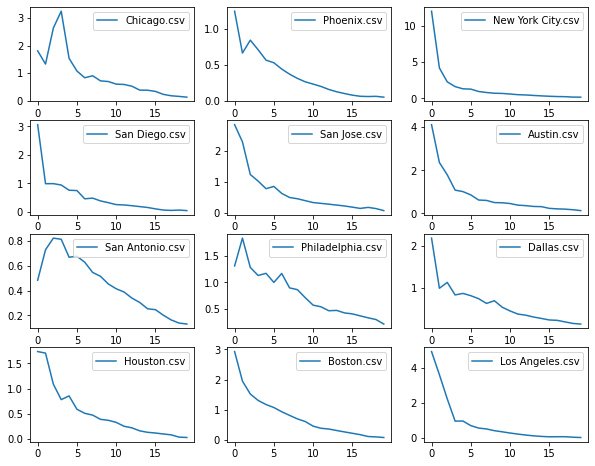

In [104]:
fig,ax = plt.subplots(4,3,figsize=(10,8))
i= 0
for city in cities:
    if '.csv' in city:
        df = binfDict[city]
        df = df.reset_index()
        df['left'] = df['bin'].apply(lambda x: x.split(',')[0].split('(')[1]).astype(float)
        df = df.sort_values(by='left')
        ax[i//3,i%3].plot(range(len(df)),df['f(d)'],label=city)
        ax[i//3,i%3].legend()
        i += 1
        

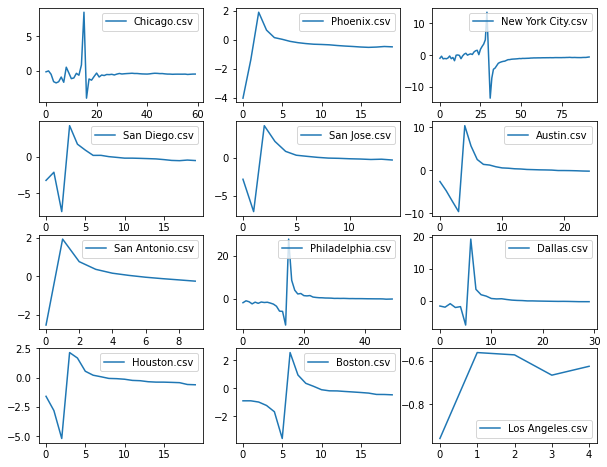

In [105]:
fig,ax = plt.subplots(4,3,figsize=(10,8))
i= 0
for city in cities:
    if '.csv' in city:
        df = binpieceDict[city]
        df = df.reset_index()
        df['left'] = df['bin'].apply(lambda x: x.split(',')[0].split('(')[1]).astype(float)
        df = df.sort_values(by='left')
        ax[i//3,i%3].plot(range(len(df)),df['f(d)'],label=city)
        ax[i//3,i%3].legend()
        i += 1
        

## insample loss function curve elbow to tune bins

In [121]:
# same k for both
mseDict = {}

cities = os.listdir('cities/')
citiesDir = 'cities/'
target = 'S000'
for city in cities:
    if '.csv' in city:
        mseBaselineList,msefdList = [],[]
        print(city)
        df = pd.read_csv(citiesDir+city)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)

        #baseline
        pars = baseline_fit(df,target)
        k = pars[0]
        df_baseline = baseline_predict(df,target,pars)
        mseBaseline = mean_squared_error(df_baseline[target+'flow'],df_baseline[target+'pred'])
        for bins in np.arange(5,100,5):
            df['bin'] = pd.cut(np.log(df['distance']), bins=bins)
            df['bin'] = df['bin'].astype(str)


            # fd
            binf = unconstrained_bucked_constant_kfit(df, target,k)
            df_fd = unconstrained_bucked_constant_predict(df,target,k,binf)
            msefd = mean_squared_error(df_fd[target+'flow'],df_fd[target+'pred'])
            mseBaselineList += [mseBaseline]
            msefdList += [msefd]

        mseDict[city] = [mseBaselineList,msefdList]


Chicago.csv
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv
Houston.csv
Boston.csv
Los Angeles.csv


In [133]:
# same k for both
cities = os.listdir('cities/')
citiesDir = 'cities/'
target = 'S000'
for city in cities:
    if '.csv' in city:
        msePieceList = []

        print(city)
        df = pd.read_csv(citiesDir+city)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)

        #baseline
        pars = baseline_fit(df,target)
        k = pars[0]
        df_baseline = baseline_predict(df,target,pars)
        mseBaseline = mean_squared_error(df_baseline[target+'flow'],df_baseline[target+'pred'])
        for bins in np.arange(5,100,5):
            df['bin'] = pd.cut(np.log(df['distance']), bins=bins)
            df['bin'] = df['bin'].astype(str)


            try:
                # piecewise
                bin_to_model = fit_piece_power_law(df,target,k)
                df_piece = predict_piece_powerlaw(df,target,bin_to_model)                
                msePiece = mean_squared_error(df[target+'flow'],df[target+'pred'])
                msePieceList += [msePiece]
            except RuntimeError:
                msePieceList += [msePiece]
                

        if len(mseDict[city]) <3:
            mseDict[city] += [msePieceList]
        elif len(mseDict[city]) ==3:
            mseDict[city][2] = msePieceList

Chicago.csv
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv
Houston.csv
Boston.csv
Los Angeles.csv


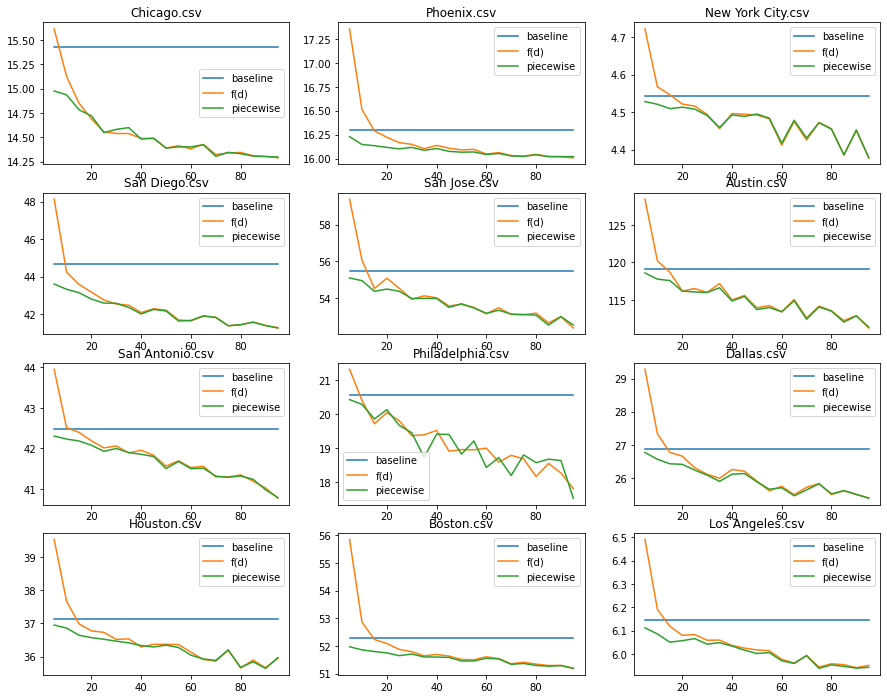

In [137]:
fig,ax = plt.subplots(4,3,figsize=(15,12))
i= 0
for city in cities:
    if '.csv' in city:
        df = mseDict[city]
        mseBaselineList,msefdList,msePieceList = df[0],df[1],df[2]
        ax[i//3,i%3].plot(np.arange(5,100,5),mseBaselineList,label='baseline')
        ax[i//3,i%3].plot(np.arange(5,100,5),msefdList,label='f(d)')
        ax[i//3,i%3].plot(np.arange(5,100,5),msePieceList,label='piecewise')
        ax[i//3,i%3].legend()
        ax[i//3,i%3].set_title(city)
        i += 1

# pd.DataFrame({'bins':np.arange(5,100,5):
#     mseDict['Chicago.csv'][0]})

# binwise MSE comparison

In [371]:

target= 'S000'
binwisemse = pd.DataFrame(index=range(20))
for city in cities:   
    if '.csv' in city:
        print(city)
        baselinemse = []
        fdmes = []
        baseline = OSDict[city][0]
        fd = OSDict[city][1]
        for i,bins in enumerate(sorted(baseline.bin.unique())):
            baselinemse += [mean_squared_error(baseline.loc[baseline['bin']==bins][target+'flow'],
                                               baseline.loc[baseline['bin']==bins][target+'pred'])]
            fdmes += [mean_squared_error(fd.loc[fd['bin']==bins][target+'flow'],
                                   fd.loc[fd['bin']==bins][target+'pred'])]
        binwisemse[city.split('.csv')[0]+'bl'] = baselinemse
        binwisemse[city.split('.csv')[0]+'fd'] = fdmes

Chicago.csv
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv
Houston.csv
Boston.csv
Los Angeles.csv


In [372]:
binwisemse

,Chicagobl,Chicagofd,Phoenixbl,Phoenixfd,New York Citybl,New York Cityfd,San Diegobl,San Diegofd,San Josebl,San Josefd,...,Philadelphiabl,Philadelphiafd,Dallasbl,Dallasfd,Houstonbl,Houstonfd,Bostonbl,Bostonfd,Los Angelesbl,Los Angelesfd
0,514.237484,228.761030,117.312359,69.719690,109.555526,98.103693,279.002918,220.793613,258.996249,289.096265,...,522.074189,456.515919,166.193235,84.139228,329.005185,181.241170,524.366196,341.648275,105.831047,99.614851
1,221.750873,110.746483,33.444551,19.752498,265.543466,242.395765,292.933770,223.734613,105.326526,41.050003,...,111.197949,97.983014,235.300816,275.396626,66.003823,48.615081,1135.641363,889.126605,73.271222,88.193507
2,209.398644,207.905066,12.046334,0.271831,242.344782,224.382503,429.817055,3094.594009,14.682587,9.949713,...,83.498765,69.379662,60.958803,80.894893,76.204153,22.618637,537.577440,275.723143,53.390921,30.037131
3,55.338920,16.313961,2433.785320,2311.481753,147.272615,136.317949,303.145785,235.722738,4134.053955,332.776608,...,149.738820,68.147862,16.905444,36.279918,135.372182,10.769224,202.390278,72.082187,37.260768,29.001676
4,154.476433,54.429049,152.160736,72.093249,959.103620,1027.391958,7174.053816,6570.154769,6105.093080,4640.905776,...,98.950262,76.763353,92.009280,128.199504,2988.895898,2338.343763,132.666274,45.453597,0.718387,2.425872
5,14.211275,20.337527,151.774057,94.943612,454.385196,410.903229,255.662047,147.001655,141.700016,105.881946,...,163.913670,198.513500,2499.177109,1755.119915,388.597182,246.852876,87.631752,200.029474,2897.059651,2811.442844
6,731.333355,687.103888,187.151930,108.637204,6.973136,9.047121,331.995866,221.459462,828.714981,693.911788,...,17.974804,47.765879,290.591629,228.749974,605.799028,379.354277,0.121422,0.000000,118.932348,107.898000
7,14158.951429,5542.080721,123.014899,73.600931,1208.843898,1130.043932,404.204601,284.830406,248.473616,125.345110,...,1926.346811,789.590703,213.430824,147.400115,516.966816,317.777256,12505.325609,10181.173958,98.014717,71.808297
8,222.187359,108.267727,91.429041,64.812390,40.935470,36.431566,301.498721,218.480688,175.235351,124.978361,...,182.654394,169.619264,218.032465,176.732800,392.150815,275.456356,480.031102,285.491214,64.188994,51.144738
9,121.054858,86.058704,61.616615,46.937264,22.463215,20.172647,225.352776,150.599180,170.394117,135.528334,...,167.054507,129.935729,387.540209,210.008718,299.085738,218.693332,306.546564,226.141529,48.426133,39.990853


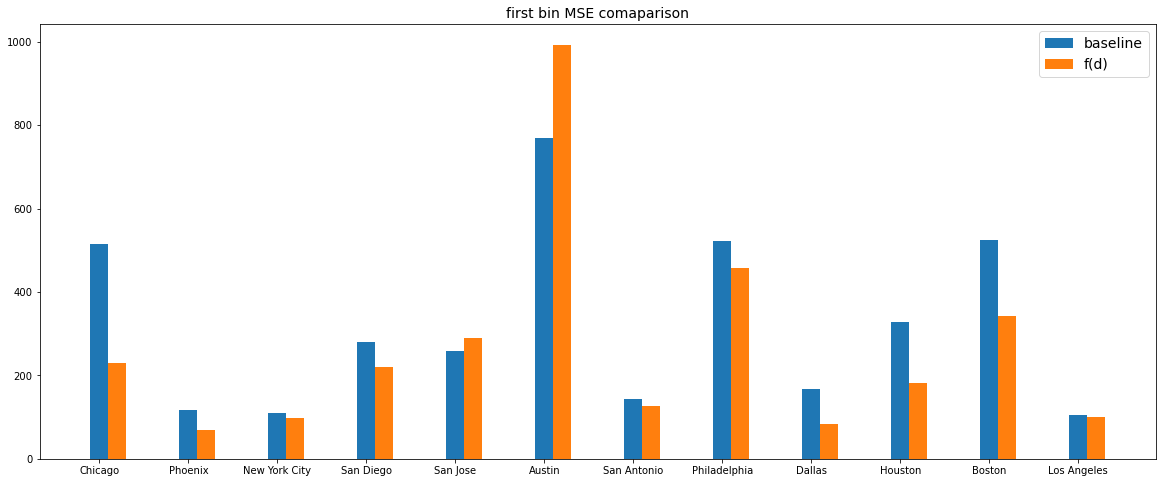

In [373]:
fig, ax = plt.subplots(figsize=(20,8))
bl = binwisemse[[col for col in binwisemse if 'bl' in col]]
ax.bar(x=range(12),height = bl.loc[0],width=0.2,label='baseline')
fd = binwisemse[[col for col in binwisemse if 'fd' in col]]
ax.bar(x=np.array(range(12))+0.2,height = fd.loc[0],width=0.2,label='f(d)')
_ = plt.xticks(range(12),[col.split('bl')[0] for col in binwisemse if 'bl' in col])
plt.title('first bin MSE comaparison',fontsize=14)
plt.legend(fontsize=14)

## bin experiement

In [123]:
city = 'Chicago.csv'
df = pd.read_csv(citiesDir+city)
bins = 20
df['bin'] = pd.qcut(df['distance'], q=bins)
df = df.sort_values(by='bin')
df['bin'] = df['bin'].astype(str)
binDict = {}
for i,j in enumerate(df.bin.unique()):
    binDict[j] = i
df['binc'] = df['bin'].apply(lambda x: binDict[x])
df['distancelog'] = np.log(df['distance'])
df['binlog'] = pd.cut(df['distancelog'], bins=bins)
df = df.sort_values(by='binlog')
df['binlog'] = df['binlog'].astype(str)
binDictlog = {}
for i,j in enumerate(df.binlog.unique()):
    binDictlog[j] = i
df['binlogc'] = df['binlog'].apply(lambda x: binDictlog[x])
df

,Unnamed: 0,origin,destination,distance,residence,jobs,flow,bin,binc,distancelog,binlog,binlogc
1648732,1648732,17031081402,17031081403,0.120030,2636,12358.0,72.0,"(0.119, 4.499]",0,-2.120015,"(-2.127, -1.79]",0
1625026,1625026,17031081403,17031081402,0.120030,4095,2397.0,11.0,"(0.119, 4.499]",0,-2.120015,"(-2.127, -1.79]",0
0,0,17031630200,17031630200,0.200000,567,909.0,18.0,"(0.119, 4.499]",0,-1.609438,"(-1.79, -1.46]",1
1056519,1056519,17031561000,17031561000,0.200000,2251,587.0,34.0,"(0.119, 4.499]",0,-1.609438,"(-1.79, -1.46]",1
1055200,1055200,17031560900,17031560900,0.200000,2271,483.0,66.0,"(0.119, 4.499]",0,-1.609438,"(-1.79, -1.46]",1
...,...,...,...,...,...,...,...,...,...,...,...,...
890368,890368,17031828402,17031801701,64.179960,1235,217.0,0.0,"(50.463, 87.827]",19,4.161691,"(4.146, 4.475]",19
1265037,1265037,17031830005,17031803901,69.950161,962,4047.0,1.0,"(50.463, 87.827]",19,4.247783,"(4.146, 4.475]",19
1392964,1392964,17031829500,17031803702,77.322886,1146,1220.0,0.0,"(50.463, 87.827]",19,4.347990,"(4.146, 4.475]",19
1350962,1350962,17031827801,17031803604,68.847987,1358,1965.0,0.0,"(50.463, 87.827]",19,4.231901,"(4.146, 4.475]",19


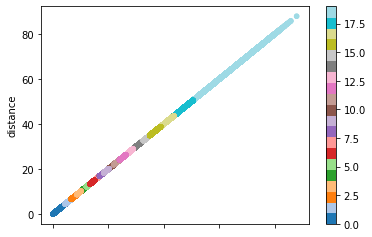

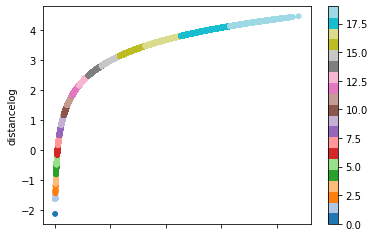

In [124]:
df.plot(kind='scatter', x='distance', y='distance', c=df['binc'], cmap='tab20')
df.plot(kind='scatter', x='distance', y='distancelog', c=df['binlogc'], cmap='tab20')
plt.show()